In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
%matplotlib inline

from modeling import Model

ModuleNotFoundError: No module named 'gpflow'

### Part 2 - Generate and recover a coregionalized kernel with corresponding outputs
-Could be useful: https://github.com/vlad17/runlmc

Links:
- https://github.com/GPflow/GPflow/pull/138 - coregion kernel
- https://github.com/GPflow/GPflow/pull/139 - coregion kernel
- https://en.wikipedia.org/wiki/Kernel_methods_for_vector_output#Linear_model_of_coregionalization_.28LMC.29  
- http://gpflow.readthedocs.io/en/latest/notebooks/coreg_demo.html?highlight=coregion  
- https://bigaidream.gitbooks.io/subsets_ml_cookbook/content/bayes/gp/coregionalized_regression_gpy.html - Gpy might be useful

- https://github.com/GPflow/GPflow/tree/master/doc/source/notebooks - GPflow notebooks from the source

### Sample Rajpaul code (implemented by DFM)

In [5]:
#Code from https://github.com/dfm/gprv/blob/master/demo.ipynb
#which in turn was inspired from Rajpaul et al. (2015)
class SimpleKernel(Model):
    parameter_names = ("log_b", )
    
    def get_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return a * np.exp(-b * tau**2)
    
    def get_grad_1_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * tau * np.exp(-b * tau**2)
    
    def get_grad_2_value(self, tau):
        a = 1.0
        b = np.exp(self.log_b)
        return 2 * a * b * np.exp(-b * tau**2) * (1.0 - 2 * b * tau**2)

class RVKernel(Model):
    parameter_names = ("vc", "vr", "lc", "bc", "br")
    
    def __init__(self, G, *args, **kwargs):
        self.G = G
        super(RVKernel, self).__init__(*args, **kwargs)
    
    def get_value(self, tau, l1, l2):
#         vc = np.exp(self.log_vc)
#         vr = np.exp(self.log_vr)
#         lc = np.exp(self.log_lc)
#         bc = np.exp(self.log_bc)
#         br = np.exp(self.log_br)
        vc = self.vc
        vr = self.vr
        lc = self.lc
        bc = self.bc
        br = self.br
        
        # Compute the value of gamma and its derivatives
        g = self.G.get_value(tau)
        gp1 = self.G.get_grad_1_value(tau)
        gp2 = self.G.get_grad_1_value(-tau)
        gpp = self.G.get_grad_2_value(tau)
        
        # We'll use these masks to build the blocked kernel matrix
        m11 = l1 == 1
        m12 = l1 == 2
        m13 = l1 == 3
        m21 = l2 == 1
        m22 = l2 == 2
        m23 = l2 == 3
        
        # Allocate the matrix and loop over blocks
        K = np.zeros_like(tau)
        zero_tau = np.isclose(tau, 0.0)
        
        # k11
        m = m11 * m21
        K[m] = vc**2*g[m] + vr**2*gpp[m] + vr*vc*(gp1 + gp2)[m]
        m &= zero_tau

        # k22
        m = m12 * m22
        K[m] = lc**2*g[m]
        m &= zero_tau

        # k33
        m = m13 * m23
        K[m] = bc**2*g[m] + br**2*gpp[m] + bc*br*(gp1 + gp2)[m]
        m &= zero_tau

        # k12
        m = m11 * m22
        K[m] = vc*lc*g[m] + vr*lc*gp2[m]
        m = m12 * m21
        K[m] = vc*lc*g[m] + vr*lc*gp1[m]

        # k13
        m = m11 * m23
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp1[m] + vr*bc*gp2[m]
        m = m13 * m21
        K[m] = vc*bc*g[m] + vr*br*gpp[m] + vc*br*gp2[m] + vr*bc*gp1[m]

        # k23
        m = m12 * m23
        K[m] = lc*bc*g[m] + lc*br*gp1[m]
        m = m13 * m22
        K[m] = lc*bc*g[m] + lc*br*gp2[m]

        return K

In [6]:
func = SimpleKernel(0.1)
kernel = RVKernel(func, 1.0, 1.0, 0.6, 0.3, 0.5)

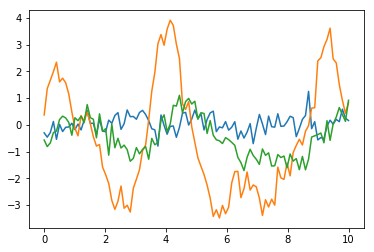

In [7]:
#generate some correlated time series according to a kernel K
npts = 100
output_dim = 3
range_ = 10

time = np.linspace(0, range_, npts)
index = np.zeros(len(time))
t, l = np.zeros(0), np.zeros(0)
for i in range(output_dim):
    t = np.concatenate((t,time))
    l = np.concatenate((l,index + i))

K = kernel.get_value(t[:, None] - t[None, :], l[:, None], l[None, :])
K[np.diag_indices(len(t))] += 0.1
y = np.random.multivariate_normal(np.zeros_like(t), K)

for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i])

### Generate True Coregional GP timeseries
Make a simple coregional matrix of:  
$$ f_1 = a_1*X_1(t)  $$
$$ f_2 = a_2*X_1(t)  $$
$$f_3 = a_3*X_1(t)   $$

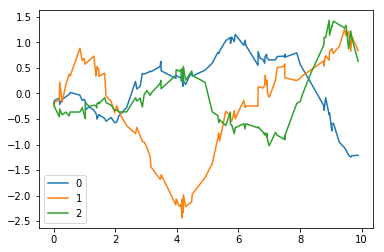

In [2]:
#https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3
#http://gpflow.readthedocs.io/en/latest/notebooks/multiclass.html
#Generate your own correlated data
npts = 100
output_dim = 3
range_ = 10
LS2 = 1   #lengthscale^2
V2 = 1      #output variance^2
noise = 1e-2 #add noise to obs

#uncorrelated data
np.random.seed(1)
X = np.random.rand(npts,1)*range_

#correlated data = uncorrelated data x Cholesky decomposition
K = V2*np.exp(-0.5*np.square(X - X.T)/LS2) + np.eye(npts)*noise
B = np.array([0.79042061, 1.2, -1])   #coregion matrix 
#B = np.array([1, 1, 1])
f = B*np.dot(np.linalg.cholesky(K), np.random.randn(npts,output_dim))
X,f = zip(*sorted(zip(X,f)))
X,f = np.asarray(X), np.asarray(f)

l,t,y = np.zeros(0), np.zeros(0), np.zeros(0)
for i in range(output_dim):
    t = np.concatenate((t,X.flatten()))
    y = np.concatenate((y,f.T[i]))
    l = np.concatenate((l,np.ones(npts)*i))

for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i], label=i);
plt.legend()

### Multi-latent functions, each with different kernel
Note: Implementation of Coregionalized Kernel in GPFlow is:  
$ B[i, j] = \sum_r W[i, r] * W[j, r] + \delta_{i,j}\kappa_i$

The Alvarez paper does not have those kappa terms. You could always force them to be zero (or small) and untrainable.



In [3]:
from gpflow.params import Parameterized
from gpflow.decors import params_as_tensors
from gpflow import Param
from gpflow.kernels import RBF, Stationary, Exponential
import tensorflow as tf

#Xavier random initialization of NN weights
def xavier(dim_in, dim_out):
    return np.random.randn(dim_in, dim_out)*(2./(dim_in+dim_out))**0.5

class NN(Parameterized):
    def __init__(self, dims):
        Parameterized.__init__(self)
        self.dims = dims
        for i, (dim_in, dim_out) in enumerate(zip(dims[:-1], dims[1:])):
            setattr(self, 'W_{}'.format(i), Param(xavier(dim_in, dim_out)))
            setattr(self, 'b_{}'.format(i), Param(np.zeros(dim_out)))

    def forward(self, X):
        if X is not None:
            for i in range(len(self.dims) - 1):
                W = getattr(self, 'W_{}'.format(i))
                b = getattr(self, 'b_{}'.format(i))
                X = tf.nn.tanh(tf.matmul(X, W) + b)
            return X

class NN_Exponential(Exponential):
    def __init__(self, nn, *args, **kw):
        Exponential.__init__(self, *args, **kw)
        self.nn = nn
    
    @params_as_tensors
    def square_dist(self, X, X2):
        return Exponential.square_dist(self, self.nn.forward(X), self.nn.forward(X2))
        
    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        return self.variance * tf.exp(-self.square_dist(X, X2) / 2)

class NN_RBF(RBF):
    def __init__(self, nn, *args, **kw):
        RBF.__init__(self, *args, **kw)
        self.nn = nn
    
    @params_as_tensors
    def square_dist(self, X, X2):
        return RBF.square_dist(self, self.nn.forward(X), self.nn.forward(X2))
        
    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        return self.variance * tf.exp(-self.square_dist(X, X2) / 2)    

#This doesnt work for some reason
# class NN_Exponential(Exponential):
#     def __init__(self, nn, *args, **kw):
#         Exponential.__init__(self, *args, **kw)
#         self.nn = nn
    
#     def square_dist(self, X, X2):
#         return Exponential.square_dist(self, self.nn.forward(X), self.nn.forward(X2))

In [32]:
#arrange data
X = np.vstack((t,l)).T
Y = np.vstack((y,l)).T

#parameters
input_dim = 1
Q = 2   #number of latent functions
R = 1   #rank of coreg matrix

#standard kernels
#k = [gpflow.kernels.Exponential(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
k = [gpflow.kernels.RBF(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
# k = [gpflow.kernels.Exponential(input_dim, lengthscales=np.random.randn(input_dim)),
#      gpflow.kernels.Matern32(input_dim, lengthscales=np.random.randn(input_dim))]

#NN kernels
# nndim = [input_dim, 10, 10]
# k = [NN_Exponential(NN(nndim), input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]

#make LMC
coreg = [gpflow.kernels.Coregion(input_dim, output_dim=output_dim, rank=R, active_dims=[1]) for q in range(Q)]
kern = coreg[0] * k[0]
for q in range(1,Q):
    kern += coreg[q] * k[q]

lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*output_dim) 
m = gpflow.models.SVGP(X, Y, kern=kern, likelihood=lik, num_latent=1, Z=X[::3].copy()) #you might want to use SGPR?!
m.compile()

#randomize coregionalization matrix W for best results
if Q > 1:
    m.kern.prod_1.coregion.W = np.random.randn(output_dim, R)
    m.kern.prod_2.coregion.W = np.random.randn(output_dim, R)
else:
    m.kern.coregion.W = np.random.randn(output_dim, R)
    #m.kern.coregion.kappa = np.zeros(output_dim) #force kappa terms to be 0 and untrainable
    #m.kern.coregion.kappa.set_trainable(False)

In [33]:
#optimize
gpflow.train.ScipyOptimizer().minimize(m, maxiter=1000)

/storage/work/ajs725/conda/install/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -164.044195
  Number of iterations: 1001
  Number of functions evaluations: 1137


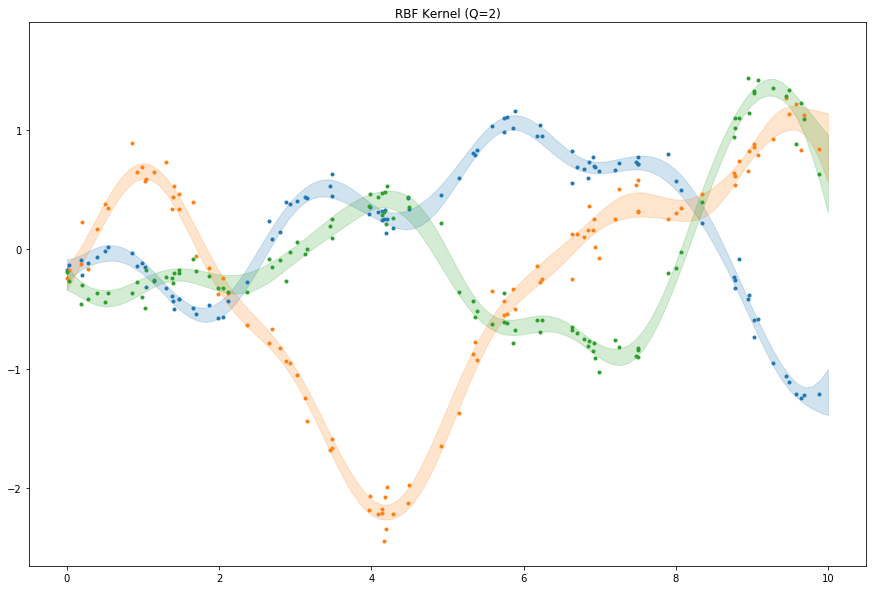

In [34]:
xtest = np.linspace(0, range_, npts)[:,None]
plt.figure(figsize=(15,10))
for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i], '.')
    mu, var = m.predict_f(np.hstack((xtest, i+np.zeros_like(xtest))))
    #plt.plot(xtest, mu, color=line.get_color(), lw=2)
    mu, var = mu.reshape(npts,), var.reshape(npts,)
    plt.fill_between(xtest.reshape(npts,), mu-2*np.sqrt(var), mu+2*np.sqrt(var), color=line.get_color(), alpha=0.2)

kernel = "RBF"    
plt.title('%s Kernel (Q=%d)'%(kernel,Q), fontsize=12)
plt.ylim([-2.65,1.9])
plt.savefig('images/%s_Q=%d.png'%(kernel,Q))

In [7]:
print(m)

<Parameter name:SVGP/kern/coregion/W [trainable] shape:(3, 1) transform:(none) prior:None>
value: [[-0.70274735],
        [ 1.34504932],
        [-0.24637099]]

<Parameter name:SVGP/kern/coregion/kappa [trainable] shape:(3,) transform:+ve prior:None>
value: [ 0.75454673,  1.12195041,  1.47866888]

<Parameter name:SVGP/kern/nn_exponential/variance [trainable] shape:() transform:+ve prior:None>
value: 0.45104318435221247

<Parameter name:SVGP/kern/nn_exponential/lengthscales [trainable] shape:(1,) transform:+ve prior:None>
value: [ 0.72437481]

<Parameter name:SVGP/kern/nn_exponential/nn/W_0 [trainable] shape:(1, 10) transform:(none) prior:None>
value: [[ 0.91143024,  0.26649779,  1.0257361 , ..., -0.25228151,
         -0.25227047, -0.2080948 ]]

<Parameter name:SVGP/kern/nn_exponential/nn/b_0 [trainable] shape:(10,) transform:(none) prior:None>
value: [ 0.30294636,  1.05597527, -0.54560976, ...,  2.46885351,
        -0.44485577,  1.53211638]

<Parameter name:SVGP/kern/nn_exponential/nn/

## SCRATCH

### Part 3 - Try and Model this with a NN kernel and/or adding multiple GPs together
- https://github.com/GPflow/GPflow/issues/505 - end-to-end NN kernel with GP on top
- https://github.com/GPflow/GPflow/issues/297#issuecomment-267765077 - combining GPs
- https://gist.github.com/john-bradshaw/11bbf17dbca013d9fc3886a7bfe46840 - end to end training of NN + GP